In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from scipy import signal, stats, optimize
from fractal_deriv import *
from observer import *
from utils import *

(1e-07, 15.280089962978053)

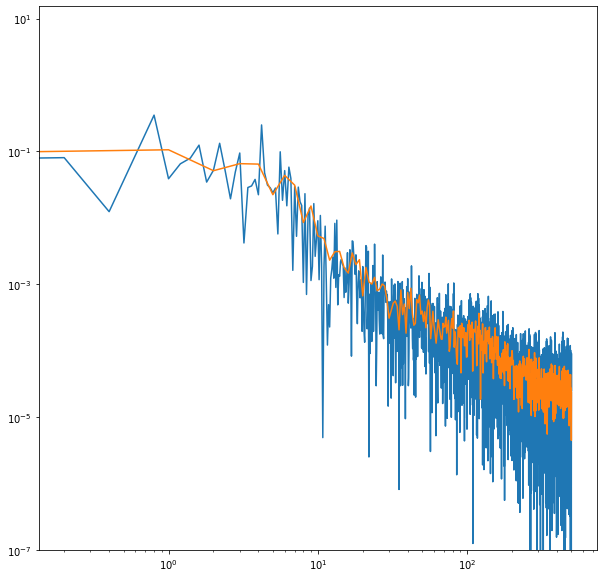

In [2]:
N = 1000
size = N // 2 + 1
num_windows = 5
pol = np.load('../telemetry/sim_openloops_0.npy')
P = np.zeros(size,)
for i in range(num_windows):
    f, P_t = signal.periodogram(pol[N * i:N * (i + 1)], fs=f_sampling)
    P += P_t
    
plt.figure(figsize=(10,10))
plt.loglog(*signal.periodogram(pol[:N * num_windows], fs=f_sampling))
plt.loglog(f, P / num_windows)
plt.ylim(1e-7)

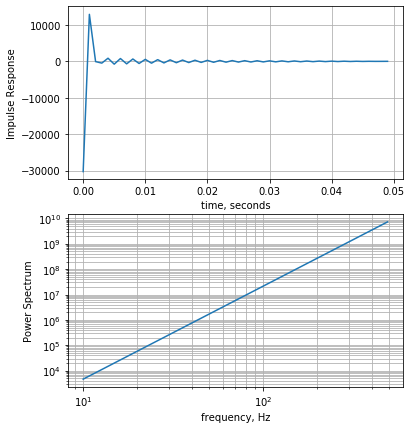

In [18]:
avg_psd = P / num_windows
x = design_filt(dt=1e-3, N=100)

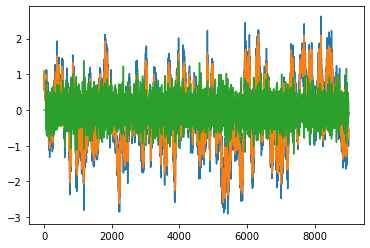

In [19]:
def track_with_impulse(pol, impulse):
    # takes in a sequence of POLs and an impulse response
    # returns a sequence of residuals 
    # first we'll do this without any noise
    residuals = np.zeros(pol.shape)
    residuals[:len(impulse)] = pol[:len(impulse)]
    for i in range(len(impulse), len(pol)):
        prediction = np.inner(pol[i-len(impulse):i], np.flip(impulse))
        residuals[i] = prediction
        
    return residuals


plt.plot(track_with_impulse(pol, x))
plt.plot(pol)
plt.plot(track_with_impulse(pol, x) - pol)